In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import torch
from torch.distributions import MultivariateNormal as MNormal, Normal
from matplotlib import pyplot as plt
import seaborn as sns

from ex2mcmc.samplers import flex2mcmc, ex2mcmc
from ex2mcmc.models.rnvp_minimal import MinimalRNVP
from ex2mcmc.models.rnvp import RNVP
from ex2mcmc.utils.general_utils import IMGS_DIR, random_seed

from utils import ema, plot_result
from ex2mcmc.pyro_samplers import NUTS, HMC

sns.set_theme('talk', style="white")

2023-04-19 21:40:32.539971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
N_CHAINS = 1
N_SAMPLES = 1500
BURN_IN = 500

PROJ_DIM1 = -1
PROJ_DIM2 = -2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
        nu - parameter
    """
    def __init__(self, dim: int, a: float=3):
        self._dim = dim
        self.a = a
        self.normal_last = Normal(0, a)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """

        normal_first = Normal(torch.zeros(x.shape[:-1], device=x.device), torch.exp(x[..., -1] / 2.))
        return normal_first.log_prob(x[..., :-1].permute(-1, *range(x.ndim-1))).sum(0) + \
            self.normal_last.log_prob(x[..., -1])
        # logprob1 = self.normal_last.log_prob(x[..., -1])
        # x1 = x[..., -1]
        # logprob2 = (
        #     -0.5 * (x[..., :-1] ** 2).sum(-1) * torch.exp(-2 * 0.5 * x1)
        #     - (self.dim - 1) * 0.5 * x1
        # )
        # return logprob1 + logprob2


    def plot_2d_countour(self, ax):
        x = np.linspace(-15, 15, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))
        ax.contour(Y, X, Z.exp(), 
                   #levels = levels,
                   levels=3, 
                   alpha=1., cmap='inferno')


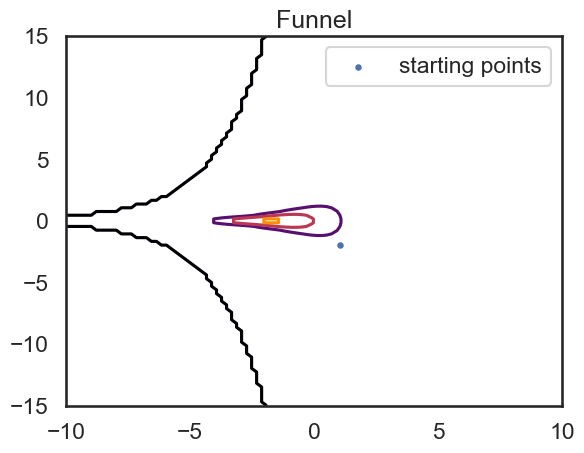

In [4]:
dim = 100
funnel = Funnel(dim=dim, a=2)
ax = plt.subplot()
funnel.plot_2d_countour(ax)

start_funnel = torch.randn((N_CHAINS, funnel.dim))
proj_slice = [-2, -1]
plt.scatter(*start_funnel[:, proj_slice].T, s=10, label='starting points')
plt.title('Funnel')
plt.legend()
plt.show()

In [6]:
step_size = 0.1

random_seed(42)

chains = NUTS(start_funnel.to(device), funnel, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

Sample: 100%|██████████| 2000/2000 [00:43, 46.49it/s, step size=5.74e-02, acc. prob=0.832] 


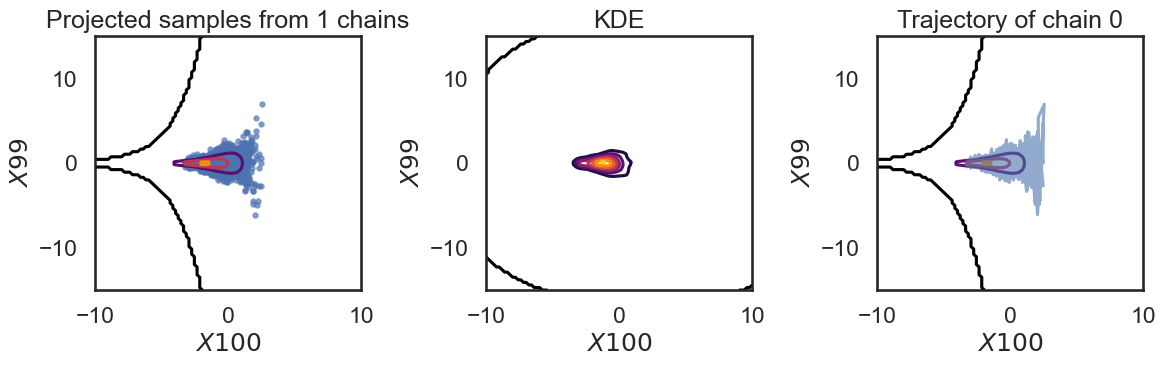

In [7]:
plot_result(chains.cpu(), funnel, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)
# plt.savefig(Path(IMGS_DIR, 'nuts_mog.png'))

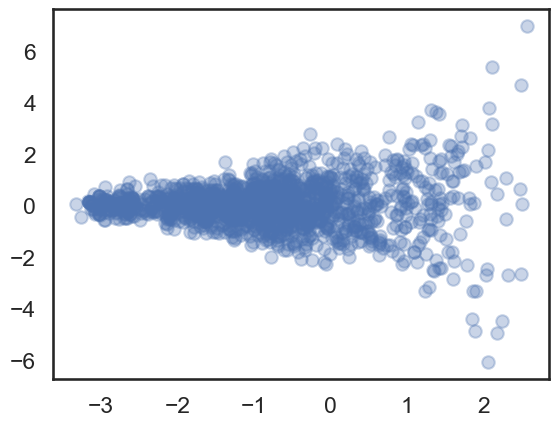

In [8]:
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title(r'NUTS samples')

In [9]:
step_size = 0.1
n_particles = 2000
n_mala_steps = 3

proposal = MNormal(torch.zeros(dim, device=device), 1 ** 2 * torch.eye(dim, device=device))

chains, meta = ex2mcmc(
    start_funnel.to(device), 
    funnel, 
    proposal, 
    N_SAMPLES,
    BURN_IN,
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps, 
    verbose=True)
chains = chains.detach().cpu()

100%|██████████| 2000/2000 [00:30<00:00, 65.07it/s]


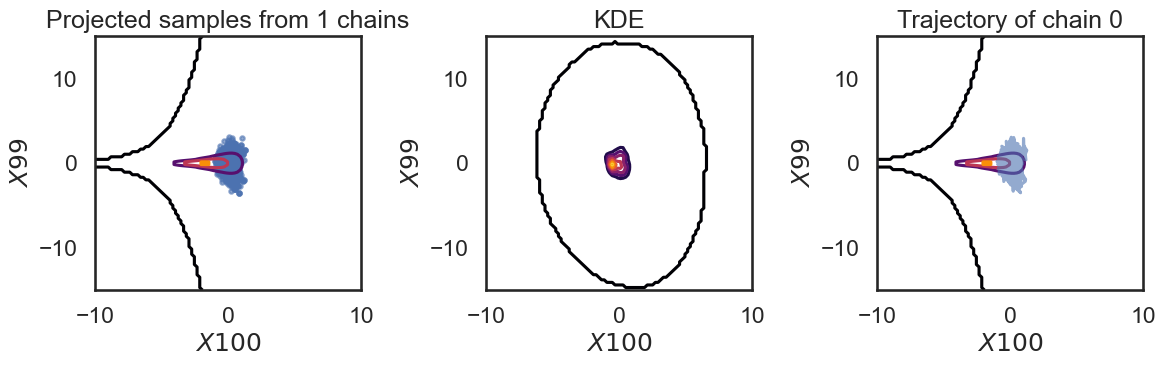

In [10]:
plot_result(chains, funnel)

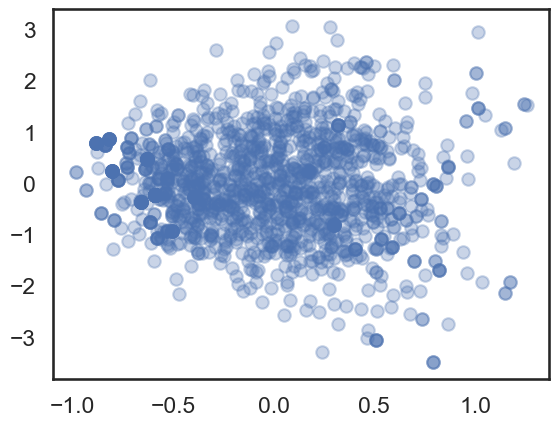

In [11]:
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title(r'Ex$^2$MCMC samples')

In [270]:
step_size = 1.0
target_acceptance = 0.67
n_particles = 200
n_mala_steps = 5
train_steps = 200
batch_size = 100
prior_scale = 1
backward_kl_weight = 0.1
forward_kl_weight = 1 - backward_kl_weight

proposal = RNVP(num_blocks=4, dim=dim, device=device, scale=prior_scale)
opt = torch.optim.Adam(proposal.parameters(), 5e-4)
proposal.optim = opt
proposal.train()
proposal.scheduler = torch.optim.lr_scheduler.LambdaLR(
    opt, lambda it: int(it < train_steps)
)

random_seed(42)

# train
flex2mcmc(
    proposal.prior.sample((batch_size,)),
    funnel, 
    proposal, 
    1,
    train_steps,
    step_size=step_size, 
    n_particles=10,
    n_mala_steps=n_mala_steps,
    forward_kl_weight=forward_kl_weight,
    backward_kl_weight=backward_kl_weight,
    target_acceptance=target_acceptance,
    verbose=True)

proposal.eval();

KL forw 131.508,                      KL back 6.198 : 100%|██████████| 201/201 [00:13<00:00, 14.59it/s] 


Text(0.5, 1.0, 'NF samples')

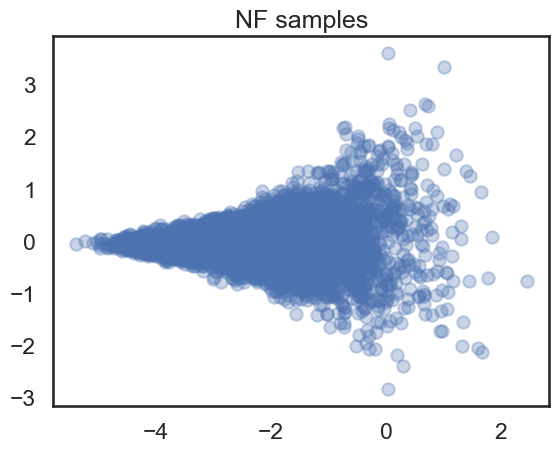

In [271]:
sample = proposal.sample((10000,)).detach().cpu()
plt.scatter(sample.view(-1, dim)[:, PROJ_DIM1], sample.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title('NF samples')

In [272]:
# sample
step_size = 0.1

chains, meta = flex2mcmc(
    start_funnel.to(device), 
    funnel, 
    proposal, 
    N_SAMPLES,
    BURN_IN,
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps, 
    target_acceptance=target_acceptance,
    verbose=True)
chains = chains.detach().cpu()

100%|██████████| 2000/2000 [00:43<00:00, 45.63it/s]


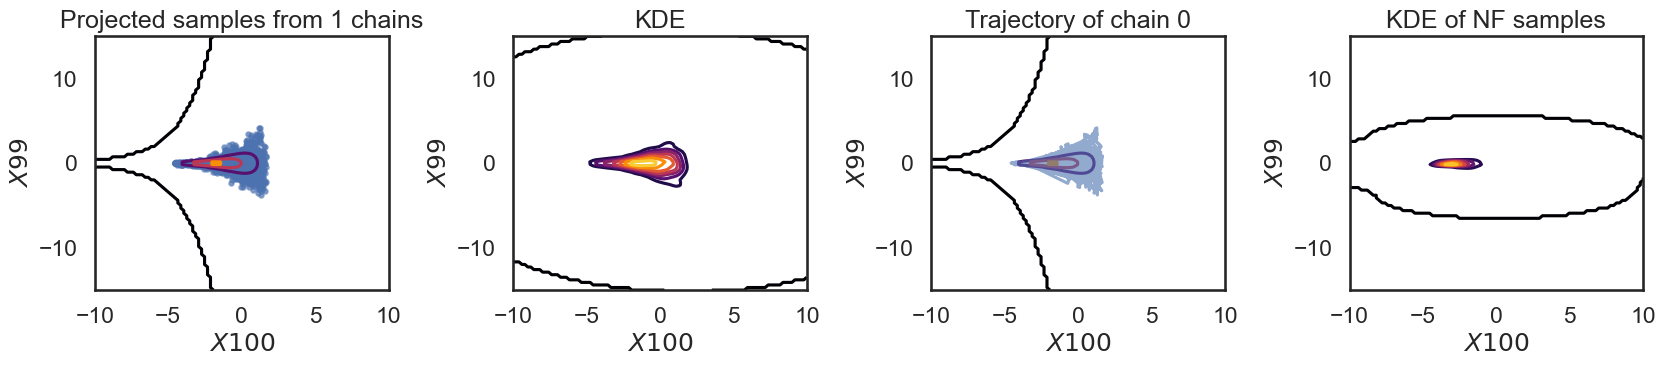

In [273]:
plot_result(chains.cpu(), funnel, proposal, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)
# plt.savefig(Path(IMGS_DIR, 'flex_funnel.png'))

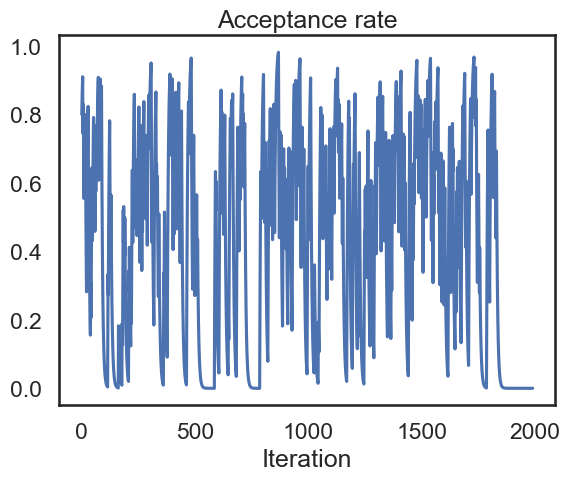

In [274]:
plt.plot(ema(meta['sir_accept'], 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
plt.show()

Text(0.5, 1.0, 'FlEx$^2$MCM samples')

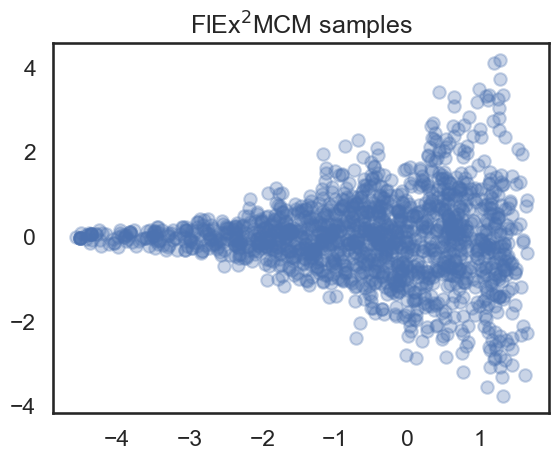

In [275]:
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title(r'FlEx$^2$MCM samples')